In [2]:
import sys
# Add the parent directory to the system path
sys.path.insert(1, r"C:\Users\keena\Documents\vscode")

from Function_files.addresses import Init_Directories
from Function_files.data_functions import read_json
import phase_comp as pc
import numpy as np
import matplotlib.pyplot as mp

dirs = Init_Directories()
dirs.current = dirs.join(dirs.code, "Phase_comp")
a_bbo = read_json(dirs.join(dirs.current, "Crystals", "a_bbo.json"))
bbo = read_json(dirs.join(dirs.current, "Crystals", "bbo.json"))
yvo = read_json(dirs.join(dirs.current, "Crystals", "yvo.json"))

pump = 0.405
temp = 20
signal = np.linspace(0.76, 0.81, 1000)
idler = 1/(1/pump-1/signal)
l_bd_pre = 12.5E3
l_bd_post = 13.3E3
l_yvo_pre = np.linspace(0, 1.4E3, 1000)
l_yvo_post = np.linspace(0, 1.4E3, 1000)
wavelengths = np.linspace(0.350, 1.200, 10000)

In [3]:
def find_x(data, x):
    return np.argmin(abs(data - x))

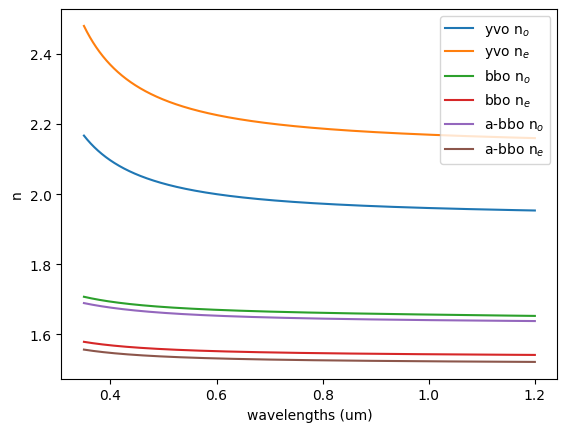

In [4]:
# calculate the refractive indexes (n_o, n_e)
yvo_n = [pc.calculate_n(wavelengths, yvo['alphas_no']), pc.calculate_n(wavelengths, yvo['alphas_ne'])]
a_bbo_n = [pc.calculate_n(wavelengths, a_bbo['alphas_no']), pc.calculate_n(wavelengths, a_bbo['alphas_ne'])]
bbo_n = [pc.calculate_n(wavelengths, bbo['alphas_no']), pc.calculate_n(wavelengths, bbo['alphas_ne'])]
# plot the refractive index
fig, ax = mp.subplots()
ax.plot(wavelengths, yvo_n[0], label='yvo n$_{o}$')
ax.plot(wavelengths, yvo_n[1], label='yvo n$_{e}$')
ax.plot(wavelengths, bbo_n[0], label='bbo n$_{o}$')
ax.plot(wavelengths, bbo_n[1], label='bbo n$_{e}$')
ax.plot(wavelengths, a_bbo_n[0], label='a-bbo n$_{o}$')
ax.plot(wavelengths, a_bbo_n[1], label='a-bbo n$_{e}$')
ax.set(xlabel='wavelengths (um)', ylabel='n')
ax.legend(loc='best')

In [5]:
pc.calculate_n(1.014, bbo['alphas_ne'])

np.float64(1.543086748817361)

In [6]:
n_po_bbo = pc.calculate_n(pump, bbo['alphas_no'])
n_pe_bbo = pc.calculate_n(pump, bbo['alphas_ne'])

n_po_bbo, n_pe_bbo

(np.float64(1.6922993830562731), np.float64(1.5679659215574717))

In [7]:
n_so_bbo = pc.calculate_n(signal, bbo['alphas_no'])
n_se_bbo = pc.calculate_n(signal, bbo['alphas_ne'])
n_io_bbo = pc.calculate_n(idler, bbo['alphas_no'])
n_ie_bbo = pc.calculate_n(idler, bbo['alphas_ne'])

In [14]:
bbo_l1 = 13E3
bbo_l2 = 13.76E3

In [15]:
delta_phi_bbo1 = pc.delta_phi(pump, bbo_l1, n_po_bbo) - pc.delta_phi(pump, bbo_l1, n_pe_bbo)
delta_phi_bbo1

np.float64(25075.88227219903)

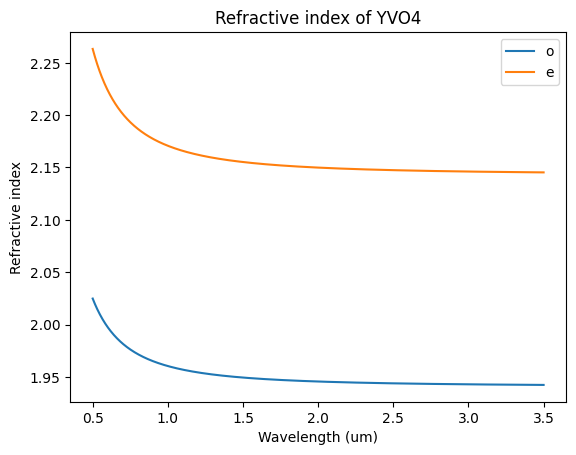

In [18]:
def yvo_sellmeier_n(wavelength, axis='o'):
    """
    Sellmeier equation for YVO4 crystal
    https://refractiveindex.info
    Birnbaum et al., 1976
    """
    if axis == 'o':
        A = 1
        B = 2.7665
        C = 0.026884
    elif axis == 'e':
        A = 1
        B = 3.5930
        C = 0.032103
    n2 = A + B * wavelength**2 / (wavelength**2 - C)
    return np.sqrt(n2)

# plot the refractive index of YVO4
wavelength = np.linspace(0.5, 3.5, 1000)
n_o = yvo_sellmeier_n(wavelength, 'o')
n_e = yvo_sellmeier_n(wavelength, 'e')
mp.plot(wavelength, n_o)
mp.plot(wavelength, n_e)
mp.legend(['o', 'e'])
mp.xlabel('Wavelength (um)')
mp.ylabel('Refractive index')
mp.title('Refractive index of YVO4')
mp.show()

In [19]:
n_e_pump_yvo4 = yvo_sellmeier_n(pump, 'e')
n_o_pump_yvo4 = yvo_sellmeier_n(pump, 'o')

In [20]:
required_yvo4_length_pre_compensation = delta_phi_bbo1 / (2 * np.pi) * pump / (n_e_pump_yvo4 - n_o_pump_yvo4) 
required_yvo4_length_pre_compensation / 1e3 # mm

np.float64(6.158254561674307)

In [24]:
yvo_l1 = delta_phi_bbo1 * pump / 2*np.pi*(n_e_pump_yvo4 - n_o_pump_yvo4)
yvo_l1 / 1E3

np.float64(4.1870183315521405)

In [ ]:
# find refractive index for the pump and signal, idler wavelengths (yvo)
yvo_pump_n = [yvo_n[0][find_x(wavelengths, pump)], yvo_n[1][find_x(wavelengths, pump)]]
yvo_signal_n = [yvo_n[0][find_x(wavelengths, signal)], yvo_n[1][find_x(wavelengths, signal)]]
yvo_idler_n = [yvo_n[0][find_x(wavelengths, idler)], yvo_n[1][find_x(wavelengths, idler)]]
# find refractive index for the pump and signal, idler wavelengths (a-bbo)
bbo_pump_n = [bbo_n[0][find_x(wavelengths, pump)], bbo_n[1][find_x(wavelengths, pump)]]
bbo_signal_n = [bbo_n[0][find_x(wavelengths, signal)], bbo_n[1][find_x(wavelengths, signal)]]
bbo_idler_n = [bbo_n[0][find_x(wavelengths, idler)], bbo_n[1][find_x(wavelengths, idler)]]
# calculate the phase of the pump (yvo)
pre_yvo_o = pc.delta_phi(pump, l_yvo_pre, yvo_pump_n[0])
pre_yvo_e = pc.delta_phi(pump, l_yvo_pre, yvo_pump_n[1])
# calculate the phase of the pump (a-bbo)
pre_bbo_o = pc.delta_phi(pump, l_bd_pre, bbo_pump_n[0])
pre_bbo_e = pc.delta_phi(pump, l_bd_pre, bbo_pump_n[1])
# calculate the phase of the signal (a-bbo)
post_bbo_so = pc.delta_phi(signal, l_bd_post, bbo_signal_n[0])
post_bbo_se = pc.delta_phi(signal, l_bd_post, bbo_signal_n[1])
# calculate the phase of the signal (yvo)
post_yvo_so = pc.delta_phi(signal, l_yvo_post, yvo_signal_n[0])
post_yvo_se = pc.delta_phi(signal, l_yvo_post, yvo_signal_n[1])
# calculate the phase of the idler (a-bbo)
post_bbo_io = pc.delta_phi(idler, l_bd_post, bbo_idler_n[0])
post_bbo_ie = pc.delta_phi(idler, l_bd_post, bbo_idler_n[1])
# calculate the phase of the idler (yvo)
post_yvo_io = pc.delta_phi(idler, l_yvo_post, yvo_idler_n[0])
post_yvo_ie = pc.delta_phi(idler, l_yvo_post, yvo_idler_n[1])

In [ ]:
mp.plot((pre_yvo_e + pre_bbo_e + post_bbo_so + post_yvo_so) - (pre_yvo_o + pre_bbo_o + post_bbo_se + post_yvo_se), label='signal')
mp.plot((pre_yvo_e + pre_bbo_e + post_bbo_io + post_yvo_io) - (pre_yvo_o + pre_bbo_o + post_bbo_ie + post_yvo_ie), label='idler')
mp.legend(loc='best')

In [ ]:
pre_yvo_e_tile = np.tile(pre_yvo_e, (len(l_yvo_pre), 1))
pre_yvo_o_tile = np.tile(pre_yvo_o, (len(l_yvo_post), 1))

In [ ]:
hh_s = pre_yvo_e_tile + pre_bbo_e + post_bbo_so + post_yvo_so
vv_s = pre_yvo_o_tile + pre_bbo_o + post_bbo_se + post_yvo_se
hh_i = pre_yvo_e_tile + pre_bbo_e + post_bbo_io + post_yvo_io
vv_i = pre_yvo_o_tile + pre_bbo_o + post_bbo_ie + post_yvo_ie

delta_s = (hh_s - vv_s)/2*np.pi
delta_i = (hh_i - vv_i)/2*np.pi

In [ ]:
mp.matshow(delta_s)

In [ ]:
mp.matshow(delta_i)

In [ ]:
mp.matshow(delta_s-delta_i)

In [ ]:
hh = []
for i_1, a in enumerate(pre_yvo_o):
    temp = []
    for i_2, b in enumerate(post_yvo_se):
        temp.append(a + pre_bbo_o + post_bbo_se + b)
    hh.append(temp)

vv = []
for i_1, a in enumerate(pre_yvo_e):
    temp = []
    for i_2, b in enumerate(post_yvo_so):
        temp.append(a + pre_bbo_e + post_bbo_so + b)
    vv.append(temp)

In [ ]:
mp.matshow(hh)

In [ ]:
mp.matshow(vv)

In [ ]:
mp.matshow(np.array(hh)-np.array(vv))
mp.colorbar()

In [ ]:
hh_np = pre_yvo_o[:, None] + pre_bbo_o + post_bbo_se + post_yvo_se[None, :]

In [ ]:
mp.matshow(hh_np)